# Real ou Fake News? Eleições Brasileiras 2018

## Introdução

Você confia em todas as notícias que ouve nas redes sociais? Como você detectar notícias falsas?

O que são fake news?

Notícias falsas (fake news) englobam peças de notícias que podem ser boatos e geralmente são disseminadas por meio das mídias sociais e outras mídias online. Isso geralmente é feito para promover ou impor certas idéias e geralmente é alcançado com agendas políticas. Essas notícias podem conter afirmações falsas e/ou exageradas e podem acabar sendo viralizadas por algoritmos, e os usuários podem acabar em uma bolha de filtro. 

## Dataset

O dataset usado é um conjunto de notícias que foram espalhadas nas mídias sociais durante as eleições presidenciais brasileiras no ano de 2018.

Link do dataset: <a href="https://www.kaggle.com/caiovms/brazilian-election-fake-news-2018" target="_blanck">Kaggle - Brazilian Election Fake News 2018</a>

## Objetivos:

1. Criar modelos que possam separar fake news e notícias verdadeiras das eleições de 2018.

2. Criar duas listas de palavras presentes nas notícias, uma em notícias verdadeiras (lista confiável) e outra em fake news (desconfiável).  

## Importando as Bibliotecas e os Dados

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize,sent_tokenize
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.svm import SVC

from wordcloud import WordCloud


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MichelinJV\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MichelinJV\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\MichelinJV\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
dados = pd.read_csv("rumor-election-brazil-2018.csv",delimiter=";")
dados.head()

,id,texto,rotulo,fonte
0,1,"Salário Mínimo: R$ 950,00. Bolsa Presidiário: ...",FALSO,AOS FATOS
1,2,Empresa contratada pelo TSE para apuração dos ...,FALSO,AOS FATOS
2,3,"O Aloizio Mercadante, ministro da Educação, mo...",FALSO,AOS FATOS
3,4,Há um complô espalhando fake news descaradas e...,FALSO,AOS FATOS
4,5,"Somente em 2017, mais de 800 milhões de tonela...",VERDADE,AOS FATOS


In [3]:
print(f"O dataset possui um total de {dados.shape[0]} notícias.") 

O dataset possui um total de 460 notícias.


## Limpando os Dados

Vamos transformar as palavras em minúsculas, remover colchetes, links, palavras contendo números e pontuações.

Limpar nossos dados de texto é importante para que o modelo não receba ruídos que não ajudariam na previsão.


In [4]:
def clean_text(text):
    
    text = str(text).lower() 
    text = re.sub('\[.*?\]','', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+','', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    return text

dados['texto'] = dados['texto'].apply(lambda x:clean_text(x))

## Removendo 'stop words'

Stop words são palavras comuns que não transmitem informação, por exemplo: "é", "pois", "o,a,os,as"

In [5]:
stop = stopwords.words('portuguese')
dados['texto'] = dados['texto'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

## Lemmatizar palavras

As palavras devem ser lematizadas para que apenas as palavras raiz sejam retidas nos dados e alimentadas no modelo.

In [6]:
def lemmatize_words(text):
    wnl = nltk.stem.WordNetLemmatizer()
    lem = ' '.join([wnl.lemmatize(word) for word in text.split()])    
    return lem

dados['texto'] = dados['texto'].apply(lemmatize_words)

## Dividindo os dados em conjunto de Treino e Teste

In [7]:
y = dados['rotulo']
X = dados['texto']

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=53)

## Usando o modelo 'Bag of words' para transformação de dados

Como estamos lidando com dados de texto, não podemos alimentá-los diretamente em nosso modelo. Portanto, vamos  usar a ferramenta *CountVectorizer* para extrair recursos de nossos dados de texto e convertê-los em vetores de recursos numéricos que podem ser alimentados diretamente para o algoritmo.

In [8]:
std_list = nltk.corpus.stopwords.words('portuguese')

In [9]:
count_vectorizer = CountVectorizer(stop_words=std_list)

count_train = count_vectorizer.fit_transform(X_train.values)
count_test = count_vectorizer.transform(X_test.values)

print(f"Treino: {count_train.shape}")
print(f"Teste: {count_test.shape}")

Treino: (368, 1545)
Teste: (92, 1545)


## MODELOS
Aqui usamos 3 modelos diferentes:
* Naive Bayes Classifier: é um classificador probabilístico simples baseado na aplicação do teorema de Bayes (da estatística Bayesiana) com uma forte suposição de independência (ingênuas) dos recursos das classes.

* Support Vector Machine: O objetivo do algoritmo é encontrar um hiperplano em um espaço N-dimensional (N - o número de recursos) que classifica distintamente os pontos de dados. 

* Passive-Aggressive Classifier: é um algoritmo de aprendizagem online que só atualiza seus pesos (ação "agressiva") quando encontra exemplos para os quais suas previsões estão erradas, mas de outra modo permanece inalterado (ação "passiva"). 

In [10]:
# Função que desenha a matriz de confusão
def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred, labels=['FALSO','VERDADE'])
    clr = classification_report(y_test, y_pred, labels=['FALSO','VERDADE'])
    
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
    plt.xticks(ticks=[0.5, 1.5], labels=['FALSO','VERDADE'])
    plt.yticks(ticks=[0.5, 1.5], labels=['FALSO','VERDADE'])
    plt.xlabel("Predição")
    plt.ylabel("Real")
    plt.title("Matriz de Confusão")
    plt.show()

### Naive Bayes

              precision    recall  f1-score   support

       FALSO       0.73      0.74      0.74        47
     VERDADE       0.73      0.71      0.72        45

    accuracy                           0.73        92
   macro avg       0.73      0.73      0.73        92
weighted avg       0.73      0.73      0.73        92



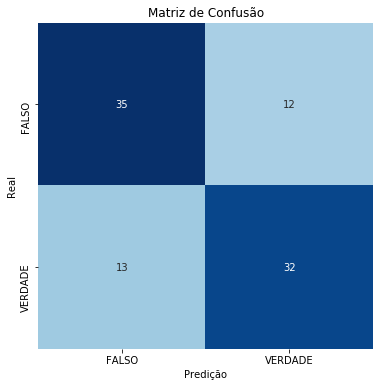

In [11]:
nb_classifier1 = MultinomialNB(alpha=10)
nb_classifier1.fit(count_train, y_train)

pred1 = nb_classifier1.predict(count_test)

print(classification_report(y_test, pred1, target_names = ['FALSO','VERDADE']))

plot_confusion_matrix(y_test,pred1)

### Support Vector Machine (SVM)



              precision    recall  f1-score   support

       FALSO       0.75      0.77      0.76        47
     VERDADE       0.75      0.73      0.74        45

    accuracy                           0.75        92
   macro avg       0.75      0.75      0.75        92
weighted avg       0.75      0.75      0.75        92



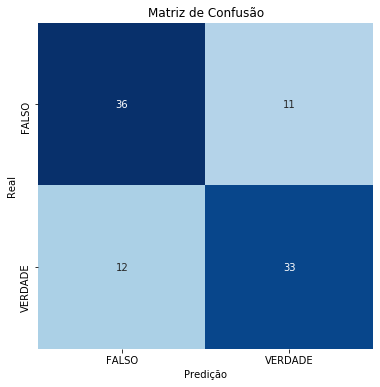

In [12]:
svc_model2 = SVC(kernel='rbf', gamma= 0.2)
svc_model2.fit(count_train, y_train)

prediction2 = svc_model2.predict(count_test)

print(classification_report(y_test, prediction2, target_names = ['FALSO','VERDADE']))
plot_confusion_matrix(y_test, prediction2)

### PassiveAggressiveClassifier

              precision    recall  f1-score   support

       FALSO       0.76      0.68      0.72        47
     VERDADE       0.70      0.78      0.74        45

    accuracy                           0.73        92
   macro avg       0.73      0.73      0.73        92
weighted avg       0.73      0.73      0.73        92



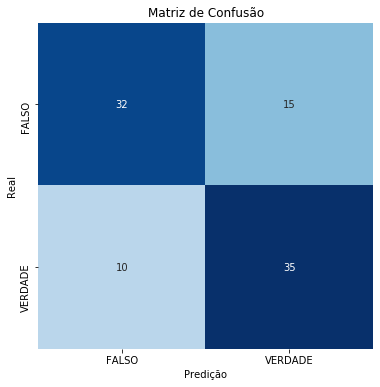

In [13]:
pac=PassiveAggressiveClassifier(C=300,max_iter=100)
pac.fit(count_train, y_train)

prediction = pac.predict(count_test)

print(classification_report(y_test, prediction, target_names = ['FALSO','VERDADE']))
plot_confusion_matrix(y_test, prediction)

## Word Cloud

Word Cloud (nuvem de palavras) é uma representação visual de dados de texto. A importância de cada palavra é mostrada com o tamanho da fonte ou cor. Este formato é útil para perceber rapidamente os termos mais proeminentes para determinar sua proeminência relativa.

In [26]:
def generate_word_cloud(texto, title, color):
    wordcloud = WordCloud(width = 800, height = 800, 
                        background_color =color,  
                        min_font_size = 20).generate(texto) 
  
    plt.figure(figsize = (15, 12)) 
    plt.imshow(wordcloud,interpolation='bilinear') 
    plt.axis("off")
    plt.title(title)
    plt.show() 

### Notícias Verdadeiras - Confiáveis

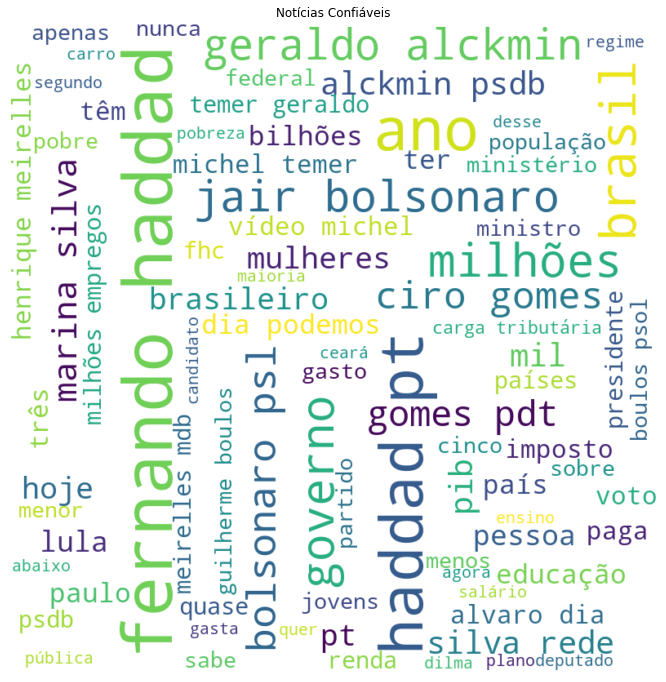

In [27]:
real_news = " ".join(dados[dados['rotulo']=="VERDADE"]['texto'])

generate_word_cloud(real_news, 'Notícias Confiáveis', 'white')

### Notícias Falsas - Desconfiar

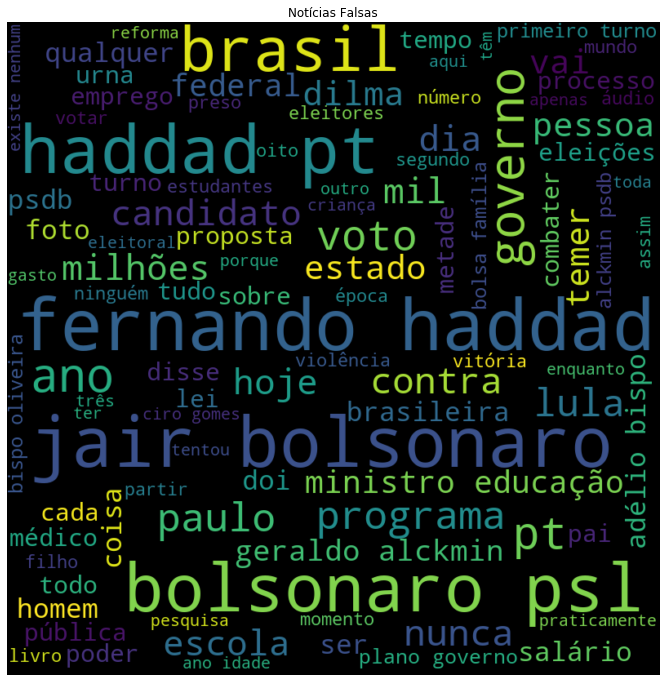

In [28]:
fake_news = " ".join(dados[dados['rotulo']=="FALSO"]['texto'])

generate_word_cloud(fake_news, 'Notícias Falsas', 'black')

## Conclusão

* **Conseguimos criar modelos que classificam as notícias como falsas ou verdadeiras.**

* **Usando o *WordCloud*, criamos uma lista de palavras presentes em notícias verdadeiras (confiáveis)) e outra lista de palvras em notícias falsas (desconfiáveis).**

